<a href="https://colab.research.google.com/github/isabelaamatto/projeto_extensao/blob/main/vigimed.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# instalação da extensão openpyxl para abrir planilhas do excel
# para arquivos no formato xls ou xlsx
%pip install openpyxl

In [ ]:
# importando as bibliotecas que serão utilizadas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import requests
from matplotlib.backends.backend_pdf import PdfPages
from io import StringIO
import csv

Carregando os arquivos VigiMed - notificações, reações e medicamentos

In [ ]:
# abrindo os arquivos no formato csv
# o parâmetro enconding especifica a codificação do arquivo
# a não utilização do encoding leva a um erro, pois o arquivo contém palavras com acento
# as palavras com acento não são interprtadas com o codificador default 'UFT-8'
# para português podemos usar enconding = 'ISO-8859-1'
# caso o enconding não seja especificado, podemos ainda aplicar o parâmetro encoding_errors,
# que irá designar o que deve ser feito com os possíveis erros ('ignore', 'replace'...)
# o parâmetro on_bad_lines='warn' é importante para que qualquer erro na leitura do arquivo seja reportado
# para mais detalhes, ver a documentação do pandas: https://pandas.pydata.org/docs/reference/api/pandas.read_csv.html#pandas.read_csv
notificacoes = pd.read_csv('VigiMed_Notificacoes.csv', sep=';', encoding='ISO-8859-1', engine='python', on_bad_lines='warn')

In [ ]:
# carregando o arquivo de reações
reacoes = pd.read_csv('VigiMed_Reacoes.csv', sep=';', encoding='ISO-8859-1', engine='python', on_bad_lines='warn')

In [ ]:
# Essa maneira de carregar o arquivo medicamentos está errada
# carregando o arquivo de medicamentos
# esse arquivo está apresentando um erro de espaçador,
# portanto, foi necessário utilizar o parâmetro 'on_bad_lines'
# on_bad_lines = 'warn' irá apenas apresentar um aviso das linhas que estão apresentando problema
# essas linhas serão puladas
# desse modo foi possível carregar o arquivo, apesar dos erros
medicamentos_errado = pd.read_csv('VigiMed_Medicamentos.csv', sep=';',
                           encoding='ISO-8859-1', engine='c', # engine='c' permite lidar com valores nulos, o que resolveu parte dos problemas
                           on_bad_lines='warn')

<ipython-input-4-2557cc5cdedb>:7: ParserWarning: Skipping line 37556: expected 22 fields, saw 24

  medicamentos = pd.read_csv('VigiMed_Medicamentos.csv', sep=';',
<ipython-input-4-2557cc5cdedb>:7: ParserWarning: Skipping line 350649: expected 22 fields, saw 24

  medicamentos = pd.read_csv('VigiMed_Medicamentos.csv', sep=';',
<ipython-input-4-2557cc5cdedb>:7: ParserWarning: Skipping line 386729: expected 22 fields, saw 27

  medicamentos = pd.read_csv('VigiMed_Medicamentos.csv', sep=';',
<ipython-input-4-2557cc5cdedb>:7: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  medicamentos = pd.read_csv('VigiMed_Medicamentos.csv', sep=';',


**Os erros apresentados na importação do arquivo VigiMed_Medicamentos trouxeram a necessidade de investigá-los melhor e corrigí-los, para evitar problemas futuros**

Corrigindo as linhas com problema do arquivo VigiMed_Medicamentos

In [ ]:
# abrir no modo de leitura
f = open("VigiMed_Medicamentos.csv", "r", encoding='ISO-8859-1')
conteudo = [line.strip() for line in f] # cria uma lista do conteudo
f.close()


In [ ]:
# verificando a quantidade de linhas da tabela medicamentos aberta em modo de leitura
# Isso é importante, pois, quando a lista conteudo for convertida para uma tabela (dataframe),
# esta deverá apresentar a mesma quantidade de linhas (436946)
len(conteudo)

436946

In [ ]:
# contando o número de linhas diretamente no arquivo VigiMed_Medicamentos.csv
# observamos que o número de linhas é igual ao da variável conteúdo (arquivo em modo de leitura)
!wc -l VigiMed_Medicamentos.csv

436946 VigiMed_Medicamentos.csv


In [ ]:
# corrigindo aspas ímpares (que foram abertas e não fechadas)
# esse tipo de problema pode gerar erros na leitura do arquivo
conteudo_corrigido = [line.replace("“", '"').replace("‘", '"').replace("'", '"') for line in conteudo]

In [ ]:
# verificando se a alteração nas aspas interferiu na quantidade de linhas
len(conteudo_corrigido)

436946

In [ ]:
# verificando a existência de campos com valores nulos em conteudo
conteudo.count('NULL')

0

In [ ]:
# verificando a existência de campos com valores nulos em conteudo
conteudo.count(None)

0

In [ ]:
# verificando a existência de campos com valores nulos em conteudo_corrigido
conteudo_corrigido.count('NULL')

0

Apesar da verificação da presença de valores nulos indicar que **não há** valores nulos, ao transformar a lista conteudo em um dataframe, o parâmetro on_bad_lines='warn' indicou diversas linhas que foram puladas por conterem NULL bytes, fazendo com que a quantidade de linhas do dataframe fosse menor do que a da lista conteudo (modo de leitura). Isso indica que algumas linhas foram perdidas, o que poderia impactar futuras análises. Dessa forma, foi necessário realizar a remoção dos valores nulos, como descrito abaixo, para depois transformar a lista conteudo em dataframe. Além disso, também foi necessário especificar o nome de todas as colunas (variável 'colunas'), para que a quantidade de linhas do dataframe medicamentos ficasse exatamente igual a da lista conteudo (modo de leitura). Assim, garantimos que o arquivo foi carregado corretamente, evitando implicações em análises futuras.

In [ ]:
# removendo valores nulos
conteudo_sem_null = [line.replace('\x00', '-') for line in conteudo_corrigido]

In [ ]:
# Demonstrando o problema dos NULL bytes
# Unindo o conteúdo corrigido em uma string
conteudo_unido = "\n".join(conteudo_corrigido) # conteudo_corrigido ainda possui valores nulos
# especificando as colunas
colunas = ['IDENTIFICACAO_NOTIFICACAO', 'RELACAO_MEDICAMENTO_EVENTO', 'NOME_MEDICAMENTO_WHODRUG', 'PRINCIPIOS_ATIVOS_WHODRUG', 'CODIGO_ATC',
           'DETENTOR_REGISTRO', 'CONCENTRACAO', 'COMPONENTE_SUSPEITO', 'ACAO_ADOTADA', 'PROBLEMAS_ADICIONAIS_RELCIONADOS_MEDICAMENTO', 'INDICACAO_MEDDRA',
           'INDICACAO_RELATADA_NOTIFICADOR_INICIAL', 'DOSE', 'FREQUENCIA_DOSE', 'POSOLOGIA', 'DURACAO', 'INICIO_ADMINISTRACAO', 'FIM_ADMINISTRACAO',
           'FORMA_FARMACEUTICA', 'VIA_ADMINISTRACAO', 'VIA_ADMINISTRACAO_MAE_PAI', 'NUMELO_LOTE']
# Carregar com pandas
df_errado = pd.read_csv(StringIO(conteudo_unido), sep=';', encoding='ISO-8859-1', names=colunas, engine='python', quoting=csv.QUOTE_NONE, on_bad_lines='warn')

<ipython-input-10-ed8caf47f321>:10: ParserWarning: Skipping line 4694: NULL byte detected. This byte cannot be processed in Python's native csv library at the moment, so please pass in engine='c' instead

  df_errado = pd.read_csv(StringIO(conteudo_unido), sep=';', encoding='ISO-8859-1', names=colunas, engine='python', quoting=csv.QUOTE_NONE, on_bad_lines='warn')
<ipython-input-10-ed8caf47f321>:10: ParserWarning: Skipping line 5429: NULL byte detected. This byte cannot be processed in Python's native csv library at the moment, so please pass in engine='c' instead

  df_errado = pd.read_csv(StringIO(conteudo_unido), sep=';', encoding='ISO-8859-1', names=colunas, engine='python', quoting=csv.QUOTE_NONE, on_bad_lines='warn')
<ipython-input-10-ed8caf47f321>:10: ParserWarning: Skipping line 5432: NULL byte detected. This byte cannot be processed in Python's native csv library at the moment, so please pass in engine='c' instead

  df_errado = pd.read_csv(StringIO(conteudo_unido), sep=';', en

KeyboardInterrupt: 

In [ ]:
# verificando a quantidade de linhas do df_errado
df_errado.shape

(436476, 22)

In [ ]:
# Demonstrando como a ausência da variável colunas deixa o dataframe com uma linha a menos
# Unindo o conteúdo corrigido em uma string
conteudo_unido = "\n".join(conteudo_sem_null) # já com os valores nulos removidos
# Carregar com pandas sem o parametro names=colunas
df_errado2 = pd.read_csv(StringIO(conteudo_unido), sep=';', encoding='ISO-8859-1', engine='python', quoting=csv.QUOTE_NONE, on_bad_lines='warn')

In [ ]:
# verificando a quantidade de linhas do df_errado2
df_errado2.shape

(436945, 22)

In [ ]:
# A seguir, a maneira correta de ralizar a conversão da lista conteudo no dataframe medicamentos
# para obter a quantidade de 436946 linhas (igual a lista conteudo)
# Unindo o conteúdo corrigido em uma string
conteudo_unido = "\n".join(conteudo_sem_null)
# especificando as colunas
colunas = ['IDENTIFICACAO_NOTIFICACAO', 'RELACAO_MEDICAMENTO_EVENTO', 'NOME_MEDICAMENTO_WHODRUG', 'PRINCIPIOS_ATIVOS_WHODRUG', 'CODIGO_ATC',
           'DETENTOR_REGISTRO', 'CONCENTRACAO', 'COMPONENTE_SUSPEITO', 'ACAO_ADOTADA', 'PROBLEMAS_ADICIONAIS_RELCIONADOS_MEDICAMENTO', 'INDICACAO_MEDDRA',
           'INDICACAO_RELATADA_NOTIFICADOR_INICIAL', 'DOSE', 'FREQUENCIA_DOSE', 'POSOLOGIA', 'DURACAO', 'INICIO_ADMINISTRACAO', 'FIM_ADMINISTRACAO',
           'FORMA_FARMACEUTICA', 'VIA_ADMINISTRACAO', 'VIA_ADMINISTRACAO_MAE_PAI', 'NUMELO_LOTE']
# Carregar com pandas
medicamentos = pd.read_csv(StringIO(conteudo_unido), sep=';', encoding='ISO-8859-1', names=colunas, engine='python', quoting=csv.QUOTE_NONE, on_bad_lines='warn')



In [ ]:
# verificando a quantidade de linhas do dataframe medicamentos
medicamentos.shape

(436946, 22)

**Outro problema observado é a repetição de IDs na coluna IDENTIFICACAO_NOTIFICACAO das tabelas VigiMed. Precisamos avaliar se essa repetição se trata de linhas idênticas que podem ser removidas, ou se há outro motivo para os IDs serem repetidos (mais de umm medicamento notificado para o mesmo ID, por exemplo).**

Verificando e removendo linhas duplicadas

In [ ]:
# verificando a presença de linhas exatamente iguais, que podemos descartar, na tabela notificacoes
notificacoes.duplicated().sum()

0

In [ ]:
# verificando a presença de linhas exatamente iguais, que podemos descartar, na tabela reacoes
reacoes.duplicated().sum()

4454

In [ ]:
# verificando a presença de linhas exatamente iguais, que podemos descartar, na tabela medicamentos
medicamentos.duplicated().sum()

1469

In [ ]:
# teste para a remoção das duplicatas
teste_sem_duplicatas = reacoes.drop_duplicates()
# avaliando se as duplicatas foram removidas
teste_sem_duplicatas.duplicated().sum()

0

In [ ]:
# removendo as duplicatas dos dataframes reacoes e medicamentos
reacoes_sem_duplicatas = reacoes.drop_duplicates()
medicamentos_sem_duplicatas = medicamentos.drop_duplicates()
# verificando se as duplicatas foram removidas
print(reacoes_sem_duplicatas.duplicated().sum())
print(medicamentos_sem_duplicatas.duplicated().sum())

0
0


Filtrando as colunas de intresse dos dataframes notificacoes, reacoes e medicamentos

In [ ]:
notificacoes_filtrado = notificacoes[['RECEBIDO_DE', 'IDENTIFICACAO_NOTIFICACAO', 'DATA_INCLUSAO_SISTEMA', 'DATA_ULTIMA_ATUALIZACAO', 'DATA_NOTIFICACAO', 'TIPO_NOTIFICACAO', 'DATA_NASCIMENTO', 'IDADE_MOMENTO_REACAO', 'SEXO', 'REACAO_EVENTO_ADVERSO_MEDDRA', 'GRAVE']]

In [ ]:
reacoes_filtrado = reacoes_sem_duplicatas[['IDENTIFICACAO_NOTIFICACAO', 'REACAO_EVTO_ADVERSO_MEDDRA_LLT', 'PT', 'SOC', 'DURACAO', 'GRAVIDADE', 'DESFECHO']]

In [ ]:
medicamentos_filtrado = medicamentos_sem_duplicatas[['IDENTIFICACAO_NOTIFICACAO', 'RELACAO_MEDICAMENTO_EVENTO', 'NOME_MEDICAMENTO_WHODRUG', 'PRINCIPIOS_ATIVOS_WHODRUG',
                                      'CODIGO_ATC', 'CONCENTRACAO', 'COMPONENTE_SUSPEITO', 'ACAO_ADOTADA', 'PROBLEMAS_ADICIONAIS_RELCIONADOS_MEDICAMENTO', 'INDICACAO_MEDDRA', 'INDICACAO_RELATADA_NOTIFICADOR_INICIAL',
                                      'DOSE', 'FREQUENCIA_DOSE', 'POSOLOGIA', 'DURACAO', 'FORMA_FARMACEUTICA', 'VIA_ADMINISTRACAO']]

In [ ]:
# Observamos a presença de caracteres _x000D_ no data frame notificacoes filtrado
notificacoes_filtrado.head()

,RECEBIDO_DE,IDENTIFICACAO_NOTIFICACAO,DATA_INCLUSAO_SISTEMA,DATA_ULTIMA_ATUALIZACAO,DATA_NOTIFICACAO,TIPO_NOTIFICACAO,DATA_NASCIMENTO,IDADE_MOMENTO_REACAO,SEXO,REACAO_EVENTO_ADVERSO_MEDDRA,GRAVE
0,Empresa Farmacêutica,BR-ANVISA-300212656,20230928,20230928.0,NaN,Notificação espontânea,19900131.0,30 ano,Feminino,Hemiparesia,Sim
1,Empresa Farmacêutica,BR-ANVISA-300208322,20230901,20230901.0,NaN,Notificação espontânea,NaN,NaN,Feminino,Cefaleia_x000D_|Gestação_x000D_|Hemorragia_x00...,Não_x000D_|Não_x000D_|Sim_x000D_|Não
2,Empresa Farmacêutica,BR-ANVISA-300214015,20231006,20231006.0,NaN,Notificação espontânea,19710522.0,49 ano,Masculino,Nefrolitíase_x000D_|Polineuropatia,Sim_x000D_|Sim
3,Empresa Farmacêutica,BR-ANVISA-300212385,20230927,20230927.0,NaN,Notificação espontânea,NaN,NaN,Masculino,Abscesso nasal_x000D_|Influenza,Sim_x000D_|Não
4,Empresa Farmacêutica,BR-ANVISA-300212764,20230929,20230929.0,NaN,Notificação espontânea,19820505.0,39 ano,Masculino,Descompensação metabólica diabética_x000D_|Hip...,Sim_x000D_|Sim


Obrsevamos a presença do caractere _x000D_ em algumas linhas do dataframe notificacoes_filtrado (mostrado na célula acima). Esse caracter aparece nas três planilhas (notificacoes, reacoes e medicamentos), mesmo quando abertas em um editor de texto, o que indica que a presença dele não é um problema no carregamento dos arquivos, mas sim, ocasionado durante a geração do arquivo. Isso geralmente acontece quando arquivos CSV são manipulados entre sistemas com diferentes convenções de quebra de linha (Windows usa \r\n, enquanto Unix e Linux usam apenas \n).

In [ ]:
# Como não é um problema no carregamento do arquivo, podemos apenas remover os caracteres _x000D_ dos arquivos
# Substitui _x000D_ em todas as colunas do DataFrame
notificacoes_filtrado = notificacoes_filtrado.replace('_x000D_', '', regex=True)
medicamentos_filtrado = medicamentos_filtrado.replace('_x000D_', '', regex=True)
reacoes_filtrado = reacoes_filtrado.replace('_x000D_', '', regex=True)


In [ ]:
# Observando se a remoção de _x000D_ ocorreu de maneira correta
notificacoes_filtrado.head()

,RECEBIDO_DE,IDENTIFICACAO_NOTIFICACAO,DATA_INCLUSAO_SISTEMA,DATA_ULTIMA_ATUALIZACAO,DATA_NOTIFICACAO,TIPO_NOTIFICACAO,DATA_NASCIMENTO,IDADE_MOMENTO_REACAO,SEXO,REACAO_EVENTO_ADVERSO_MEDDRA,GRAVE
0,Empresa Farmacêutica,BR-ANVISA-300212656,20230928,20230928.0,NaN,Notificação espontânea,19900131.0,30 ano,Feminino,Hemiparesia,Sim
1,Empresa Farmacêutica,BR-ANVISA-300208322,20230901,20230901.0,NaN,Notificação espontânea,NaN,NaN,Feminino,Cefaleia|Gestação|Hemorragia|Dor abdominal,Não|Não|Sim|Não
2,Empresa Farmacêutica,BR-ANVISA-300214015,20231006,20231006.0,NaN,Notificação espontânea,19710522.0,49 ano,Masculino,Nefrolitíase|Polineuropatia,Sim|Sim
3,Empresa Farmacêutica,BR-ANVISA-300212385,20230927,20230927.0,NaN,Notificação espontânea,NaN,NaN,Masculino,Abscesso nasal|Influenza,Sim|Não
4,Empresa Farmacêutica,BR-ANVISA-300212764,20230929,20230929.0,NaN,Notificação espontânea,19820505.0,39 ano,Masculino,Descompensação metabólica diabética|Hipersensi...,Sim|Sim


Avaliação inicial do preenchimento das notificações

In [ ]:
# Contagem de valores preenchidos e faltantes para o notificacoes
notificacoes_missing = notificacoes_filtrado.isnull().sum()
notificacoes_filled = notificacoes_filtrado.notnull().sum()
noti_missing_filled = pd.DataFrame({'Missing':notificacoes_missing, 'Filled':notificacoes_filled})

<ipython-input-30-981c22b346b8>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  labels = [f'{(v / total_values_noti[i] * 100):.1f}%' if total_values_noti.iloc[i] > 0 else ''


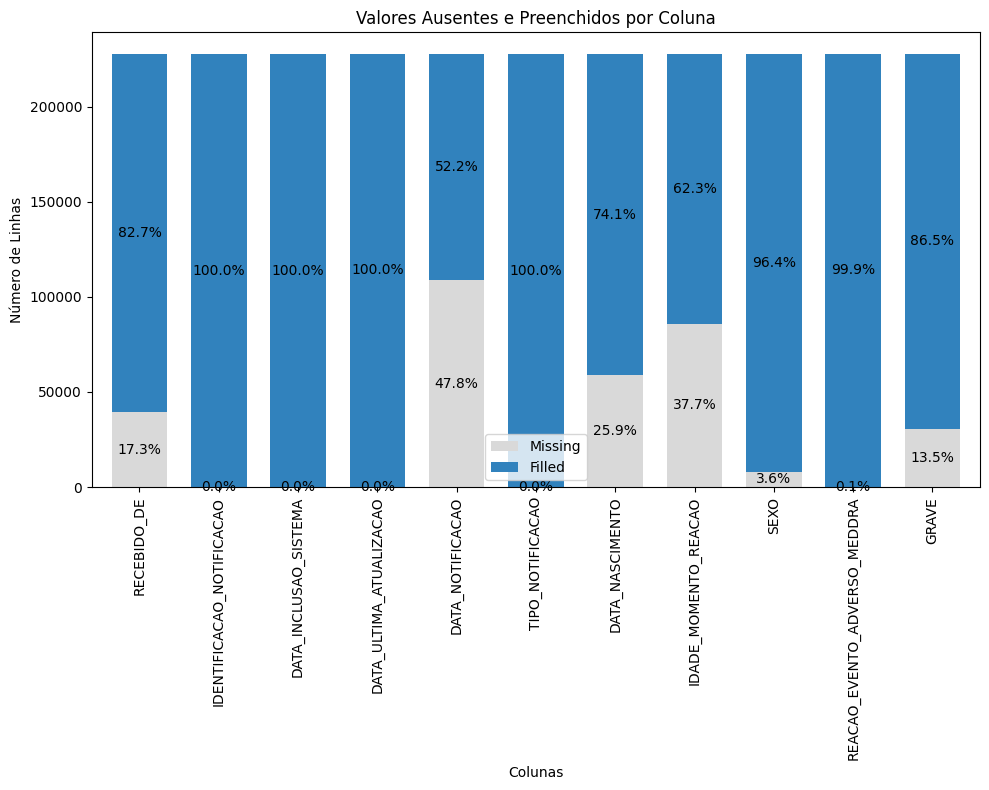

In [ ]:
# Gráfico de barras empilhadas com porcentagens como rótulos - Dataframe Notificações
# Calculando o total por coluna para obter as porcentagens
total_values_noti = noti_missing_filled.sum(axis=1)

fig, ax = plt.subplots(figsize=(10, 8))

# Cria as barras empilhadas
noti_missing_filled.plot(kind='bar', width=0.7, stacked=True, ax=ax, colormap='tab20c_r')

# Adiciona rótulos às barras
for container in ax.containers:
    labels = [f'{(v / total_values_noti[i] * 100):.1f}%' if total_values_noti.iloc[i] > 0 else ''
              for i, v in enumerate(container.datavalues)]
    ax.bar_label(container, labels=labels, label_type='center')

# Ajusta os rótulos e layout
plt.xlabel('Colunas')
plt.ylabel('Número de Linhas')
plt.title('Valores Ausentes e Preenchidos por Coluna')
plt.xticks(rotation=90)
plt.tight_layout()

plt.show()


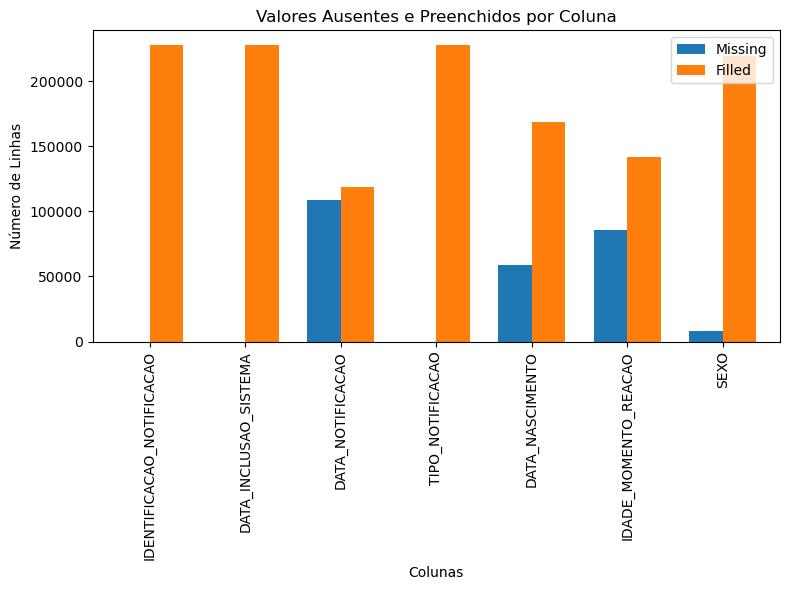

In [ ]:
# Gráfico de barras - Dataframe Notificações
noti_missing_filled.plot(kind='bar', figsize=(8, 6), width=0.7)
plt.xlabel('Colunas')
plt.ylabel('Número de Linhas')
plt.title('Valores Ausentes e Preenchidos por Coluna')
plt.xticks(rotation=90)  # Deixa os rótulos das colunas na horizontal
plt.tight_layout()
plt.show()

In [ ]:
# Contagem de valores preenchidos e faltantes para reacoes
reacoes_missing = reacoes_filtrado.isnull().sum()
reacoes_filled = reacoes_filtrado.notnull().sum()
reac_missing_filled = pd.DataFrame({'Missing':reacoes_missing, 'Filled':reacoes_filled})

<ipython-input-32-02a335ce95bc>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  labels = [f'{(v / total_values_reac[i] * 100):.1f}%' if total_values_reac.iloc[i] > 0 else ''


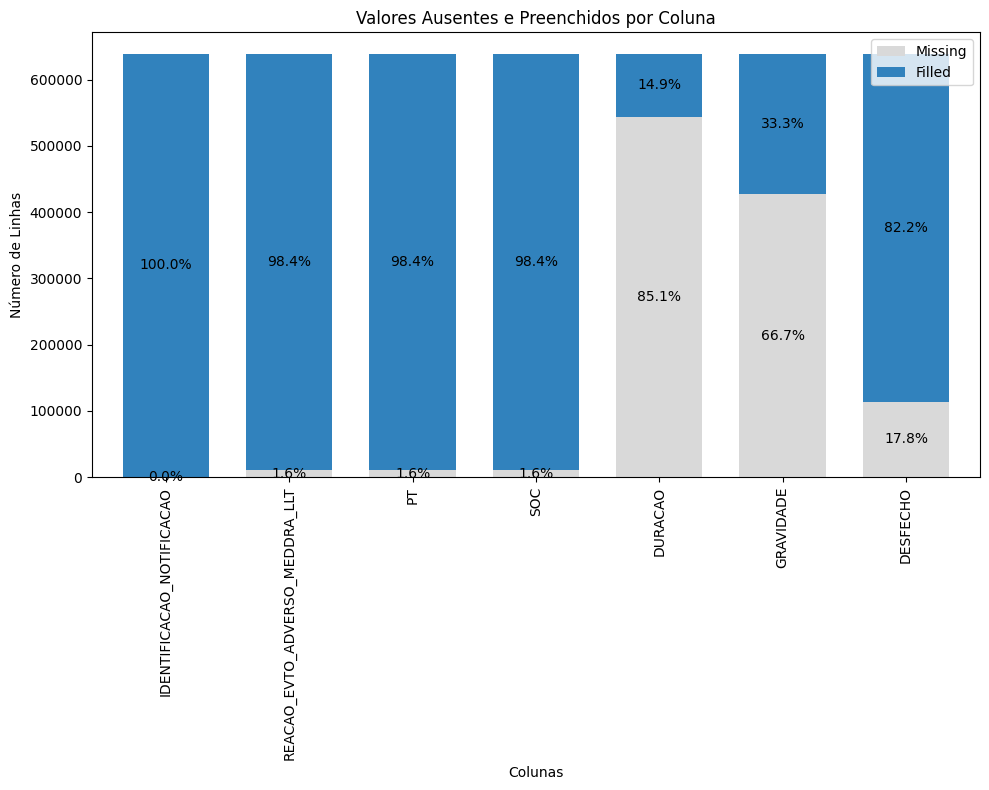

In [ ]:
# Gráfico de barras empilhadas com porcentagens como rótulos - Dataframe Reações
# Calculando o total por coluna para obter as porcentagens
total_values_reac = reac_missing_filled.sum(axis=1)

fig, ax = plt.subplots(figsize=(10, 8))

# Cria as barras empilhadas
reac_missing_filled.plot(kind='bar', width=0.7, stacked=True, ax=ax, colormap='tab20c_r')

# Adiciona rótulos às barras
for container in ax.containers:
    labels = [f'{(v / total_values_reac[i] * 100):.1f}%' if total_values_reac.iloc[i] > 0 else ''
              for i, v in enumerate(container.datavalues)]
    ax.bar_label(container, labels=labels, label_type='center')

# Ajusta os rótulos e layout
plt.xlabel('Colunas')
plt.ylabel('Número de Linhas')
plt.title('Valores Ausentes e Preenchidos por Coluna')
plt.xticks(rotation=90)
plt.tight_layout()

plt.show()

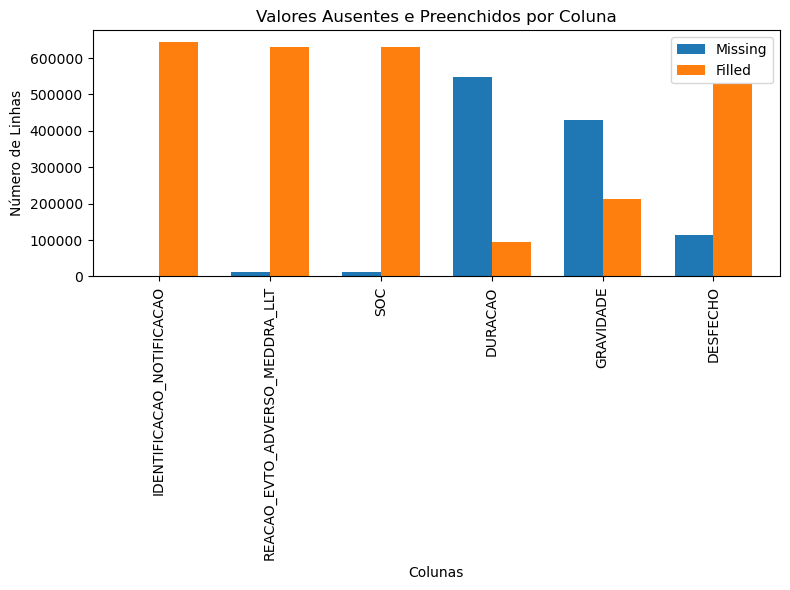

In [ ]:
# Gráfico de barras - Dataframe Reações
reac_missing_filled.plot(kind='bar', figsize=(8, 6), width=0.7)
plt.xlabel('Colunas')
plt.ylabel('Número de Linhas')
plt.title('Valores Ausentes e Preenchidos por Coluna')
plt.xticks(rotation=90)  # Deixa os rótulos das colunas na horizontal
plt.tight_layout()
plt.show()

In [ ]:
# Contagem de valores preenchidos e faltantes para medicamentos
medicamentos_missing = medicamentos_filtrado.isnull().sum()
medicamentos_filled = medicamentos_filtrado.notnull().sum()
med_missing_filled = pd.DataFrame({'Missing':medicamentos_missing, 'Filled':medicamentos_filled})

<ipython-input-34-3d22606a3321>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  labels = [f'{(v / total_values_med[i] * 100):.1f}%' if total_values_med.iloc[i] > 0 else ''


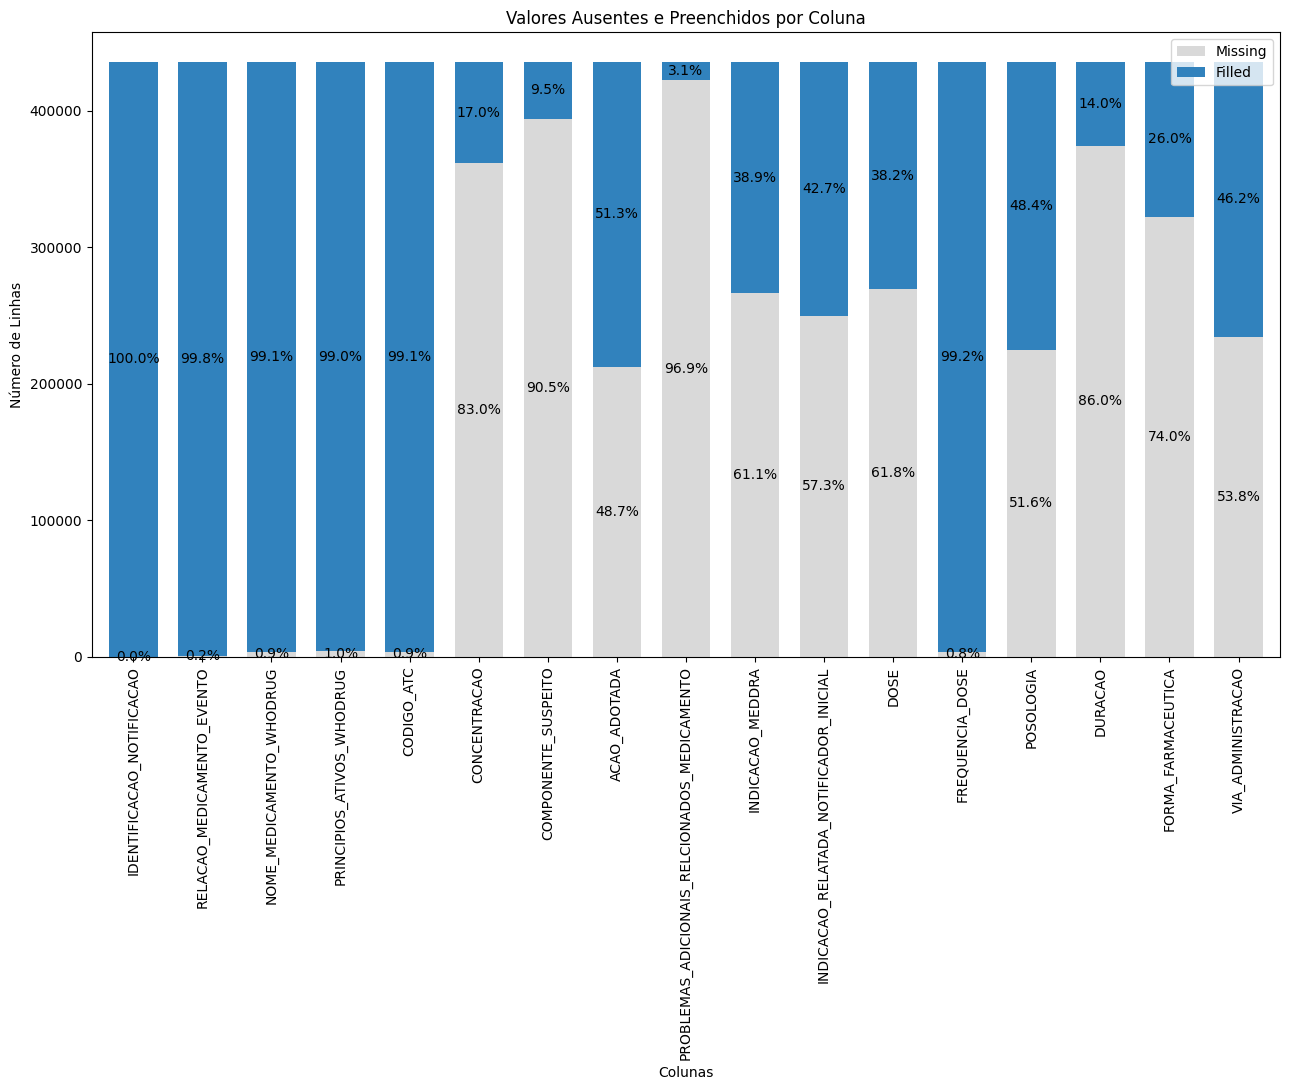

In [ ]:
# Gráfico de barras empilhadas com porcentagens como rótulos - Dataframe Medicamentos
# Calculando o total por coluna para obter as porcentagens
total_values_med = med_missing_filled.sum(axis=1)

fig, ax = plt.subplots(figsize=(13, 11))

# Cria as barras empilhadas
med_missing_filled.plot(kind='bar', width=0.7, stacked=True, ax=ax, colormap='tab20c_r')

# Adiciona rótulos às barras
for container in ax.containers:
    labels = [f'{(v / total_values_med[i] * 100):.1f}%' if total_values_med.iloc[i] > 0 else ''
              for i, v in enumerate(container.datavalues)]
    ax.bar_label(container, labels=labels, label_type='center')

# Ajusta os rótulos e layout
plt.xlabel('Colunas')
plt.ylabel('Número de Linhas')
plt.title('Valores Ausentes e Preenchidos por Coluna')
plt.xticks(rotation=90)
plt.tight_layout()

plt.show()

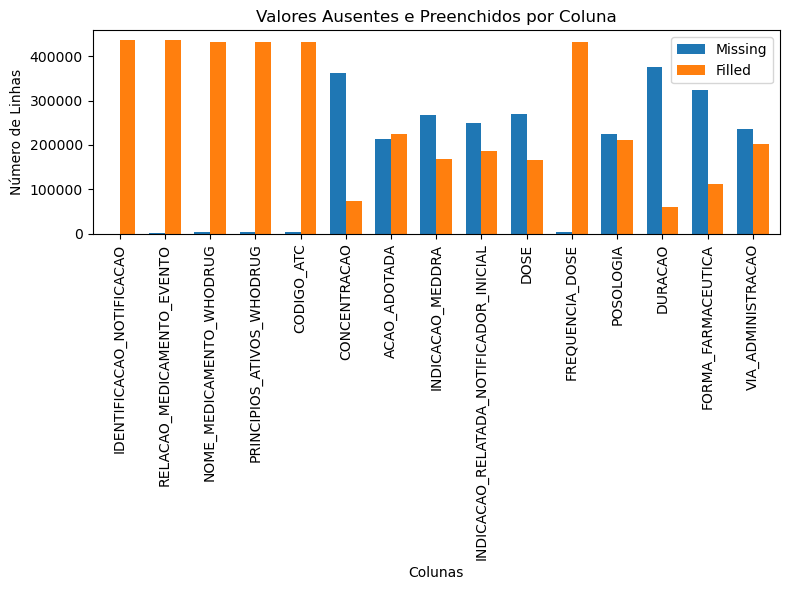

In [ ]:
# Gráfico de barras
med_missing_filled.plot(kind='bar', figsize=(8, 6), width=0.7)
plt.xlabel('Colunas')
plt.ylabel('Número de Linhas')
plt.title('Valores Ausentes e Preenchidos por Coluna')
plt.xticks(rotation=90)  # Deixa os rótulos das colunas na horizontal
plt.tight_layout()
plt.show()

**Calaculando a data de nascimento dos pacientes**

In [ ]:
# Observamos que as colunas contendo datas não estão no formato correto, mas sim, em formato float
# Isso precisará ser corrigido
notificacoes_filtrado.head()

,RECEBIDO_DE,IDENTIFICACAO_NOTIFICACAO,DATA_INCLUSAO_SISTEMA,DATA_ULTIMA_ATUALIZACAO,DATA_NOTIFICACAO,TIPO_NOTIFICACAO,DATA_NASCIMENTO,IDADE_MOMENTO_REACAO,SEXO,REACAO_EVENTO_ADVERSO_MEDDRA,GRAVE
0,Empresa Farmacêutica,BR-ANVISA-300212656,20230928,20230928.0,NaN,Notificação espontânea,19900131.0,30 ano,Feminino,Hemiparesia,Sim
1,Empresa Farmacêutica,BR-ANVISA-300208322,20230901,20230901.0,NaN,Notificação espontânea,NaN,NaN,Feminino,Cefaleia|Gestação|Hemorragia|Dor abdominal,Não|Não|Sim|Não
2,Empresa Farmacêutica,BR-ANVISA-300214015,20231006,20231006.0,NaN,Notificação espontânea,19710522.0,49 ano,Masculino,Nefrolitíase|Polineuropatia,Sim|Sim
3,Empresa Farmacêutica,BR-ANVISA-300212385,20230927,20230927.0,NaN,Notificação espontânea,NaN,NaN,Masculino,Abscesso nasal|Influenza,Sim|Não
4,Empresa Farmacêutica,BR-ANVISA-300212764,20230929,20230929.0,NaN,Notificação espontânea,19820505.0,39 ano,Masculino,Descompensação metabólica diabética|Hipersensi...,Sim|Sim


In [ ]:
# Primeiro, vamos adicionar colunas a notificacoes_filtrado
notificacoes_filtrado[['Data de Inclusão no Sistema', 'Data da Última Atualização', 'Data de Notificação', 'Data de Nascimento']] = notificacoes_filtrado[['DATA_INCLUSAO_SISTEMA', 'DATA_ULTIMA_ATUALIZACAO', 'DATA_NOTIFICACAO', 'DATA_NASCIMENTO']]


In [ ]:
# Verificando a inclusão das colunas
notificacoes_filtrado.head()

,RECEBIDO_DE,IDENTIFICACAO_NOTIFICACAO,DATA_INCLUSAO_SISTEMA,DATA_ULTIMA_ATUALIZACAO,DATA_NOTIFICACAO,TIPO_NOTIFICACAO,DATA_NASCIMENTO,IDADE_MOMENTO_REACAO,SEXO,REACAO_EVENTO_ADVERSO_MEDDRA,GRAVE,Data de Inclusão no Sistema,Data da Última Atualização,Data de Notificação,Data de Nascimento
0,Empresa Farmacêutica,BR-ANVISA-300212656,20230928,20230928.0,NaN,Notificação espontânea,19900131.0,30 ano,Feminino,Hemiparesia,Sim,2023-09-28,2023-09-28,NaT,1990-01-31
1,Empresa Farmacêutica,BR-ANVISA-300208322,20230901,20230901.0,NaN,Notificação espontânea,NaN,NaN,Feminino,Cefaleia|Gestação|Hemorragia|Dor abdominal,Não|Não|Sim|Não,2023-09-01,2023-09-01,NaT,NaT
2,Empresa Farmacêutica,BR-ANVISA-300214015,20231006,20231006.0,NaN,Notificação espontânea,19710522.0,49 ano,Masculino,Nefrolitíase|Polineuropatia,Sim|Sim,2023-10-06,2023-10-06,NaT,1971-05-22
3,Empresa Farmacêutica,BR-ANVISA-300212385,20230927,20230927.0,NaN,Notificação espontânea,NaN,NaN,Masculino,Abscesso nasal|Influenza,Sim|Não,2023-09-27,2023-09-27,NaT,NaT
4,Empresa Farmacêutica,BR-ANVISA-300212764,20230929,20230929.0,NaN,Notificação espontânea,19820505.0,39 ano,Masculino,Descompensação metabólica diabética|Hipersensi...,Sim|Sim,2023-09-29,2023-09-29,NaT,1982-05-05


In [ ]:
# Converter as datas que estão em formato float, nas colunas adicionadas, para datetime
notificacoes_filtrado['Data de Inclusão no Sistema'] = pd.to_datetime(notificacoes_filtrado['Data de Inclusão no Sistema'], format='%Y%m%d', errors='coerce')
notificacoes_filtrado['Data da Última Atualização'] = pd.to_datetime(notificacoes_filtrado['Data da Última Atualização'], format='%Y%m%d', errors='coerce')
notificacoes_filtrado['Data de Notificação'] = pd.to_datetime(notificacoes_filtrado['Data de Notificação'], format='%Y%m%d', errors='coerce')
notificacoes_filtrado['Data de Nascimento'] = pd.to_datetime(notificacoes_filtrado['Data de Nascimento'], format='%Y%m%d', errors='coerce')
# para verificar a conversão, rodar a célula de cima novamente

In [ ]:
# Verificar se há NaT nas colunas
if notificacoes_filtrado['Data de Inclusão no Sistema'].isnull().any() or notificacoes_filtrado['Data de Nascimento'].isnull().any():
    print("Existem valores NaT nas colunas de data!")

Existem valores NaT nas colunas de data!


In [ ]:
# Para calcular a idade, não usaremos a novas colunas com a data convertida
# Usaremos as colunas com as datas no formato float, para facilitar os cálculos
# Primeiro passo para o cálculo da idade
# Manter apenas os 4 primeiros dígitos (divisão inteira por 10.000)
# Isso deixará apenas o ano

notificacoes_filtrado.loc[:, 'DATA_INCLUSAO_SISTEMA'] = (notificacoes_filtrado['DATA_INCLUSAO_SISTEMA'] // 10000)
notificacoes_filtrado.loc[:, 'DATA_NASCIMENTO'] = (notificacoes_filtrado['DATA_NASCIMENTO'] // 10000)

In [ ]:
notificacoes_filtrado['DATA_NASCIMENTO'].unique()

array([1.990e+03,       nan, 1.971e+03, 1.982e+03, 1.978e+03, 1.962e+03,
       1.960e+03, 1.972e+03, 1.973e+03, 2.020e+03, 1.979e+03, 1.970e+03,
       2.011e+03, 2.014e+03, 2.013e+03, 1.956e+03, 1.963e+03, 1.991e+03,
       1.975e+03, 1.959e+03, 1.976e+03, 1.943e+03, 1.955e+03, 1.957e+03,
       1.951e+03, 1.950e+03, 1.953e+03, 1.954e+03, 1.984e+03, 1.952e+03,
       1.989e+03, 1.980e+03, 1.927e+03, 2.008e+03, 1.958e+03, 1.965e+03,
       1.945e+03, 1.934e+03, 2.021e+03, 2.010e+03, 2.012e+03, 1.987e+03,
       1.967e+03, 1.944e+03, 1.961e+03, 2.005e+03, 1.993e+03, 1.969e+03,
       1.946e+03, 1.974e+03, 1.977e+03, 2.006e+03, 1.947e+03, 1.949e+03,
       1.966e+03, 1.933e+03, 1.985e+03, 1.986e+03, 1.988e+03, 1.937e+03,
       1.994e+03, 1.940e+03, 1.992e+03, 1.942e+03, 1.968e+03, 1.981e+03,
       2.009e+03, 1.930e+03, 1.964e+03, 1.948e+03, 1.983e+03, 1.996e+03,
       2.019e+03, 2.001e+03, 1.999e+03, 1.997e+03, 1.932e+03, 1.938e+03,
       2.007e+03, 1.998e+03, 2.018e+03, 1.995e+03, 

In [ ]:
# Segundo passo para o cálculo da idade
# transformando as colunas de data em inteiros
# é necessário preencher as linhas com valores NaN com 0, para não dar erro
notificacoes_filtrado['DATA_NOTIFICACAO'] = pd.to_numeric(notificacoes_filtrado['DATA_NOTIFICACAO'], errors='coerce').fillna(0).astype(int)
notificacoes_filtrado['DATA_INCLUSAO_SISTEMA'] = pd.to_numeric(notificacoes_filtrado['DATA_INCLUSAO_SISTEMA'], errors='coerce').fillna(0).astype(int)
notificacoes_filtrado['DATA_ULTIMA_ATUALIZACAO'] = pd.to_numeric(notificacoes_filtrado['DATA_ULTIMA_ATUALIZACAO'], errors='coerce').fillna(0).astype(int)
notificacoes_filtrado['DATA_NASCIMENTO'] = pd.to_numeric(notificacoes_filtrado['DATA_NASCIMENTO'], errors='coerce').fillna(0).astype(int)

In [ ]:
notificacoes_filtrado.head()

,RECEBIDO_DE,IDENTIFICACAO_NOTIFICACAO,DATA_INCLUSAO_SISTEMA,DATA_ULTIMA_ATUALIZACAO,DATA_NOTIFICACAO,TIPO_NOTIFICACAO,DATA_NASCIMENTO,IDADE_MOMENTO_REACAO,SEXO,REACAO_EVENTO_ADVERSO_MEDDRA,GRAVE,Data de Inclusão no Sistema,Data da Última Atualização,Data de Notificação,Data de Nascimento,Idade Calculada
0,Empresa Farmacêutica,BR-ANVISA-300212656,2023,20230928,0,Notificação espontânea,1990,30 ano,Feminino,Hemiparesia,Sim,2023-09-28,2023-09-28,NaT,1990-01-31,33
1,Empresa Farmacêutica,BR-ANVISA-300208322,2023,20230901,0,Notificação espontânea,0,NaN,Feminino,Cefaleia|Gestação|Hemorragia|Dor abdominal,Não|Não|Sim|Não,2023-09-01,2023-09-01,NaT,NaT,0
2,Empresa Farmacêutica,BR-ANVISA-300214015,2023,20231006,0,Notificação espontânea,1971,49 ano,Masculino,Nefrolitíase|Polineuropatia,Sim|Sim,2023-10-06,2023-10-06,NaT,1971-05-22,52
3,Empresa Farmacêutica,BR-ANVISA-300212385,2023,20230927,0,Notificação espontânea,0,NaN,Masculino,Abscesso nasal|Influenza,Sim|Não,2023-09-27,2023-09-27,NaT,NaT,0
4,Empresa Farmacêutica,BR-ANVISA-300212764,2023,20230929,0,Notificação espontânea,1982,39 ano,Masculino,Descompensação metabólica diabética|Hipersensi...,Sim|Sim,2023-09-29,2023-09-29,NaT,1982-05-05,41


In [ ]:
# Adicionando uma coluna de idade calculada
# calcule a idade apenas se ambas as colunas DATA_INCLUSAO_SISTEMA e DATA_NASCIMENTO estiverem preenchidas

notificacoes_filtrado.loc[:, 'Idade Calculada'] = (
    notificacoes_filtrado.apply(lambda row: row['DATA_INCLUSAO_SISTEMA'] - row['DATA_NASCIMENTO'] if row['DATA_NASCIMENTO'] != 0 else None, axis=1)
)


In [ ]:
# Transformando a coluna Idade Calculada em inteiros
notificacoes_filtrado['Idade Calculada'] = notificacoes_filtrado['Idade Calculada'].fillna(0).round().astype(int)

In [ ]:
notificacoes_filtrado['Idade Calculada'].unique()

array([  33,    0,   52,   41,   46,   62,   64,   51,    4,   45,   54,
         13,   53,    9,   10,   65,   58,   30,   49,   79,   60,   66,
         61,   70,   71,   59,   68,   67,   37,   69,   32,   43,   94,
         63,   48,   57,   77,   88,    1,   31,   12,   76,   34,   55,
         87,   50,   16,   28,   75,   47,   44,   15,   35,   72,   56,
         78,   36,   17,   39,   73,   84,   27,   82,   29,   40,   81,
         91,   38,   42,   25,   26,    2,   23,   22,   74,   24,   89,
         83,   14,    3,   86,   90,    5,   20,  100,   85,   80,   93,
         96,   99,   92,   11,  104,   18,    8,    6,   95,   19,   21,
          7,  102,  101,   97,   98,  107,  103, 2000,  109, 1977,  105,
       1844, 1943, 1956, 1823, 1834, 2002, 1922,  127, 1966, 1039, 2001,
        106,   -1, 1822, 2012, 1926,  121, 2019, 2003,  122, 1827, 1961,
        -77,  330, 1968,  111, 1973, 1940,   -6,  -22, 2004, 1937,  833,
        117, 1949, 1970,  327,  112, 2005,   -4, 18

In [ ]:
# junção dos dados de reacoes e medicamentos
dados_totais = pd.merge(reacoes_filtrado, medicamentos_filtrado, on='IDENTIFICACAO_NOTIFICACAO', how='inner')

In [ ]:
# adição dos dados de notifcacoes ao dataframe dados_totais
dados_totais = pd.merge(dados_totais, notificacoes_filtrado, on='IDENTIFICACAO_NOTIFICACAO', how='inner')

In [ ]:
# Verificando a presença de duplicatas no dataframe dados_totais
dados_totais.duplicated().sum()

0

In [ ]:
# Removendo as linhas duplicadas
dados_totais.drop_duplicates(inplace=True)

In [ ]:
dados_totais.head()

,IDENTIFICACAO_NOTIFICACAO,REACAO_EVTO_ADVERSO_MEDDRA_LLT,PT,SOC,DURACAO_x,GRAVIDADE,DESFECHO,RELACAO_MEDICAMENTO_EVENTO,NOME_MEDICAMENTO_WHODRUG,PRINCIPIOS_ATIVOS_WHODRUG,...,VIA_ADMINISTRACAO,DATA_INCLUSAO_SISTEMA,DATA_NOTIFICACAO,TIPO_NOTIFICACAO,DATA_NASCIMENTO,IDADE_MOMENTO_REACAO,SEXO,Data de Inclusão no Sistema,Data de Nascimento,Idade Calculada
0,BR-ANVISA-300000004,Coceira,Prurido,Distúrbios dos tecidos cutâneos e subcutâneos,3 dia,NaN,Recuperado/Resolvido,Suspeito,Oxacilina,Oxacillin sodium,...,infusão intravenosa,2018,20181127,Notificação espontânea,0,2 ano,Masculino,2018-12-01,NaT,0
1,BR-ANVISA-300000005,Edema periorbital,Edema periorbital,Distúrbios oculares,NaN,Outro efeito clinicamente significativo,Recuperado/Resolvido,Suspeito,Paracemol,Paracetamol,...,oral,2018,20181212,Notificação espontânea,0,10 ano,Feminino,2018-12-12,NaT,0
2,BR-ANVISA-300000007,Exantema alérgico,Dermatite alérgica,Distúrbios dos tecidos cutâneos e subcutâneos,2 dia,Outro efeito clinicamente significativo,Recuperado/Resolvido,Suspeito,Diamox,Acetazolamide sodium,...,oral,2018,20181212,Notificação espontânea,0,45 ano,Masculino,2018-12-12,NaT,0
3,BR-ANVISA-300000007,Exantema alérgico,Dermatite alérgica,Distúrbios dos tecidos cutâneos e subcutâneos,2 dia,Outro efeito clinicamente significativo,Recuperado/Resolvido,Suspeito,Hidantal,Phenytoin,...,oral,2018,20181212,Notificação espontânea,0,45 ano,Masculino,2018-12-12,NaT,0
4,BR-ANVISA-300000008,Flebite,Flebite,Distúrbios vasculares,5 dia,Outro efeito clinicamente significativo,Recuperado/Resolvido,Suspeito,Nitroglicerina,Glyceryl trinitrate,...,infusão intravenosa,2018,20181027,Notificação espontânea,0,66 ano,Feminino,2018-12-01,NaT,0


Trabalhando com os dicionários

In [ ]:
# carregando o dicionário dos medicamentos psicotropicos
psicotropicos = pd.read_excel('Medicamentos_registrados_psicotrópicos.xlsx')

In [ ]:
# carregando o dicionário dos medicamentos antibióticos
antibioticos = pd.read_excel('Medicamentos_registrados_antibióticos.xlsx')

In [ ]:
# carregando o dicionário das reações adversas
dic_ram = pd.read_excel('DicionárioRAM.xlsx')

In [ ]:
# criando um dataframe com a coluna Nomes do dataframe psicotropicos
dic_psicotropicos = pd.melt(psicotropicos, value_vars=['Nome Base', 'Nome do Produto', 'Princípio Ativo'], var_name='column', value_name='combined')
# removendo a coluna com a categoria (de qual coluna do df psicotropicos veio) dos nomes
dic_psicotropicos.drop(columns=['column'], inplace=True)
# removendo os nomes repetidos
dic_psicotropicos.drop_duplicates(inplace=True)


In [ ]:
# Removendo parte escrita entre ()
dic_psicotropicos['combined'] = dic_psicotropicos['combined'].str.replace(r'\s*\(.*\)\s*$', '', regex=True)

In [ ]:
# Removendo parte escrita de linhas específicas
dic_psicotropicos.loc[668, 'combined'] = dic_psicotropicos.loc[668, 'combined'].replace(' (PORT 344/98 LISTA', '')
dic_psicotropicos.loc[1032, 'combined'] = dic_psicotropicos.loc[1032, 'combined'].replace(' - Port 344/98 - Lista B1', '')

In [ ]:
# Renomeando uma coluna
antibioticos.rename(columns={'Unnamed: 0':'Nome Base'}, inplace=True)

In [ ]:
# criando um dataframe com a coluna Nomes do dataframe antibioticos
dic_antibioticos = pd.melt(antibioticos, value_vars=['Nome Base', 'Nome do Produto', 'Princípio Ativo'], var_name='column', value_name='combined')
# removendo a coluna com a categoria (de qual coluna do df psicotropicos veio) dos nomes
dic_antibioticos.drop(columns=['column'], inplace=True)
# removendo os nomes repetidos
dic_antibioticos.drop_duplicates(inplace=True)


In [ ]:
# Removendo parte escrita de linhas específicas
dic_antibioticos.loc[286, 'combined'] = dic_antibioticos.loc[286, 'combined'].replace(' (2)', '')
dic_antibioticos.loc[465, 'combined'] = dic_antibioticos.loc[465, 'combined'].replace(' (2)', '')

In [ ]:
# Removendo eventuais duplicatas e missing values
dic_psicotropicos.drop_duplicates(inplace=True)
dic_antibioticos.drop_duplicates(inplace=True)
dic_psicotropicos.dropna(inplace=True)
dic_antibioticos.dropna(inplace=True)


Avaliação inicial das reações adversas

In [ ]:
# avaliação inicial das reações adversas
frequencia_reacoes = reacoes['REACAO_EVTO_ADVERSO_MEDDRA_LLT'].value_counts() # a função values_counts conta a frequência de cada termo
frequencia_reacoes_top10 = frequencia_reacoes[:10] # selecionando as 10 reções mais frequentes

In [ ]:
frequencia_reacoes_sem_filtro = pd.DataFrame(frequencia_reacoes)

In [ ]:
frequencia_reacoes_sem_filtro.head()

,count
REACAO_EVTO_ADVERSO_MEDDRA_LLT,
Cefaleia,13465
Prurido,12173
Febre,11722
Náusea,11497
Diarreia,8565


In [ ]:
frequencia_reacoes_top10.reset_index()

,REACAO_EVTO_ADVERSO_MEDDRA_LLT,count
0,Cefaleia,13465
1,Prurido,12173
2,Febre,11722
3,Náusea,11497
4,Diarreia,8565
5,Coceira,7747
6,Calafrios,6316
7,Vômito,6193
8,Medicamento ineficaz,6113
9,Dispneia,5832


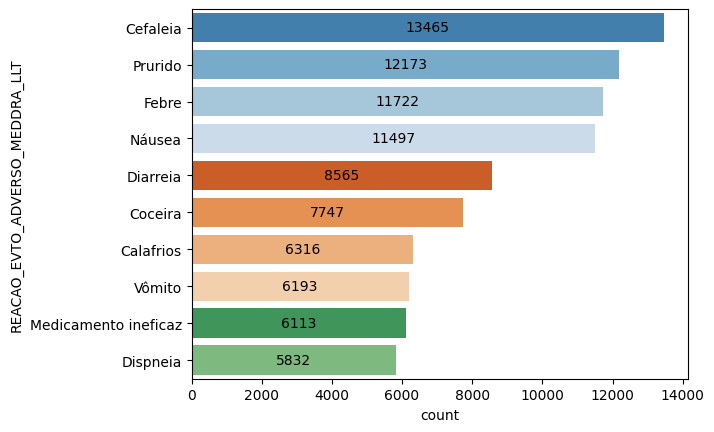

In [ ]:
# criando um gráfico de barras, utilizando a biblioteca seaborn, para visualizar as 10 reações mais frequentes
ax = sns.barplot(data=frequencia_reacoes_top10.reset_index(), x="count", y="REACAO_EVTO_ADVERSO_MEDDRA_LLT", palette="tab20c")
# adicionando os labels de cada barra
for container in ax.containers:
    ax.bar_label(container, label_type='center')
plt.show()

In [ ]:
notificacoes_filtrado.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 227651 entries, 0 to 227650
Data columns (total 7 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   IDENTIFICACAO_NOTIFICACAO  227651 non-null  object 
 1   DATA_INCLUSAO_SISTEMA      227651 non-null  int64  
 2   DATA_NOTIFICACAO           118914 non-null  float64
 3   TIPO_NOTIFICACAO           227651 non-null  object 
 4   DATA_NASCIMENTO            168777 non-null  float64
 5   IDADE_MOMENTO_REACAO       141761 non-null  object 
 6   SEXO                       219547 non-null  object 
dtypes: float64(2), int64(1), object(4)
memory usage: 12.2+ MB


Filtrando os medicamentos psicotropicos e antimicrobianos

In [ ]:
# Filtrando os psicotrópicos presentes na coluna 'PRINCIPIOS_ATIVOS_WHODRUG'
medicamentos_psi = medicamentos_filtrado[medicamentos_filtrado['PRINCIPIOS_ATIVOS_WHODRUG'].isin(dic_psicotropicos['combined'])]

In [ ]:
medicamentos_psi.head()

,IDENTIFICACAO_NOTIFICACAO,RELACAO_MEDICAMENTO_EVENTO,NOME_MEDICAMENTO_WHODRUG,PRINCIPIOS_ATIVOS_WHODRUG,CODIGO_ATC,CONCENTRACAO,COMPONENTE_SUSPEITO,ACAO_ADOTADA,PROBLEMAS_ADICIONAIS_RELCIONADOS_MEDICAMENTO,INDICACAO_MEDDRA,INDICACAO_RELATADA_NOTIFICADOR_INICIAL,DOSE,FREQUENCIA_DOSE,POSOLOGIA,DURACAO,FORMA_FARMACEUTICA,VIA_ADMINISTRACAO
33,BR-ANVISA-300000036,Concomitante,Aramin,Lorazepam,N05BA,NaN,NaN,NaN,NaN,NaN,Procedimento de parto,NaN,NaN,NaN,NaN,NaN,intravenosa (não especificado)
150,BR-ANVISA-300000142,Suspeito,Clonazepam,Clonazepam,N03AE|N05BA,NaN,NaN,Retirada do medicamento,NaN,"Estado de ansiedade, não especificado",Controle ansiedade,NaN,,"2 mg, 1 comprimido 12/12h",NaN,NaN,oral
204,BR-ANVISA-300000206,Suspeito,Alprazolam,Alprazolam,N05BA,NaN,NaN,Retirada do medicamento,NaN,Insônia,insonia,0.5 milligram (mg),1,"0,5, 1",NaN,NaN,oral
206,BR-ANVISA-300000208,Suspeito,Lorazepam,Lorazepam,N03AE|N05BA,NaN,NaN,Retirada do medicamento,NaN,Ansiedade,Quadro de ansiedade,2 milligram (mg),1,"2mg, 1x/dia",NaN,NaN,oral
287,BR-ANVISA-300000323,Suspeito,Dormonid,Midazolam,N05CD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,NaN,NaN,NaN,NaN


In [ ]:
# Filtrando os antibióticos presentes na coluna 'PRINCIPIOS_ATIVOS_WHODRUG'
medicamentos_ant = medicamentos_filtrado[medicamentos_filtrado['PRINCIPIOS_ATIVOS_WHODRUG'].isin(dic_antibioticos['combined'])]

In [ ]:
# Junção das tabelas de notificações e reações
notificacoes_reacoes = pd.merge(notificacoes_filtrado, reacoes_filtrado, on='IDENTIFICACAO_NOTIFICACAO', how='inner')

In [ ]:
# Junção dos psicotrópicos filtrados com as tabelas de notificações e reações
dados_psi = pd.merge(medicamentos_psi, notificacoes_reacoes, on='IDENTIFICACAO_NOTIFICACAO', how='inner')

In [ ]:
# Junção dos antibióticos filtrados com as tabelas de notificações e reações
dados_ant = pd.merge(medicamentos_ant, notificacoes_reacoes, on='IDENTIFICACAO_NOTIFICACAO', how='inner')

In [ ]:
# Filtrando um medicamento específico
dados_psi[dados_psi['NOME_MEDICAMENTO_WHODRUG'].str.contains('clonazepam', case=False, na=False)]

,IDENTIFICACAO_NOTIFICACAO,RELACAO_MEDICAMENTO_EVENTO,NOME_MEDICAMENTO_WHODRUG,PRINCIPIOS_ATIVOS_WHODRUG,CODIGO_ATC,CONCENTRACAO,ACAO_ADOTADA,INDICACAO_MEDDRA,INDICACAO_RELATADA_NOTIFICADOR_INICIAL,DOSE,...,TIPO_NOTIFICACAO,DATA_NASCIMENTO,IDADE_MOMENTO_REACAO,SEXO,REACAO_EVTO_ADVERSO_MEDDRA_LLT,PT,SOC,DURACAO_y,GRAVIDADE,DESFECHO
0,BR-ANVISA-300000142,Suspeito,Clonazepam,Clonazepam,N03AE|N05BA,NaN,Retirada do medicamento,"Estado de ansiedade, não especificado",Controle ansiedade,NaN,...,Notificação espontânea,NaN,63 ano,Masculino,Cefaleia,Cefaleia,Distúrbios do sistema nervoso,NaN,Outro efeito clinicamente significativo,Recuperado/Resolvido
1,BR-ANVISA-300000142,Suspeito,Clonazepam,Clonazepam,N03AE|N05BA,NaN,Retirada do medicamento,"Estado de ansiedade, não especificado",Controle ansiedade,NaN,...,Notificação espontânea,NaN,63 ano,Masculino,Sonolência,Sonolência,Distúrbios do sistema nervoso,NaN,Outro efeito clinicamente significativo,Recuperado/Resolvido
2,BR-ANVISA-300000142,Suspeito,Clonazepam,Clonazepam,N03AE|N05BA,NaN,Retirada do medicamento,"Estado de ansiedade, não especificado",Controle ansiedade,NaN,...,Notificação espontânea,NaN,63 ano,Masculino,Cefaleia,Cefaleia,Distúrbios do sistema nervoso,NaN,Outro efeito clinicamente significativo,Recuperado/Resolvido
3,BR-ANVISA-300000142,Suspeito,Clonazepam,Clonazepam,N03AE|N05BA,NaN,Retirada do medicamento,"Estado de ansiedade, não especificado",Controle ansiedade,NaN,...,Notificação espontânea,NaN,63 ano,Masculino,Sonolência,Sonolência,Distúrbios do sistema nervoso,NaN,Outro efeito clinicamente significativo,Recuperado/Resolvido
17,BR-ANVISA-300000757,Suspeito,Clonazepam,Clonazepam,N03AE|N05BA,NaN,NaN,NaN,NaN,2 milligram (mg),...,Notificação espontânea,19311010.0,NaN,Feminino,Perda sensorial,Perda sensorial,Distúrbios do sistema nervoso,NaN,Resultou em óbito,Fatal/Óbito
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52275,BR-ANVISA-300273123,Concomitante,Clonazepam qualitest,Clonazepam,N03AE,NaN,Sem alteração da dose,Uso de medicamento para indicação desconhecida,NaN,2 milligram (mg),...,Notificação espontânea,NaN,45 ano,Feminino,Infecção,Infecção,Infecções e infestações,NaN,NaN,Desconhecido
52276,BR-ANVISA-300273123,Concomitante,Clonazepam qualitest,Clonazepam,N03AE,NaN,Sem alteração da dose,Uso de medicamento para indicação desconhecida,NaN,2 milligram (mg),...,Notificação espontânea,NaN,45 ano,Feminino,Evento adverso,Evento adverso,Distúrbios gerais e quadros clínicos no local ...,NaN,NaN,Desconhecido
52277,BR-ANVISA-300273123,Concomitante,Clonazepam qualitest,Clonazepam,N03AE,NaN,Sem alteração da dose,Uso de medicamento para indicação desconhecida,NaN,2 milligram (mg),...,Notificação espontânea,NaN,45 ano,Feminino,Fístula,Fístula,Distúrbios musculoesqueléticos e do tecido con...,NaN,NaN,Desconhecido
52278,BR-ANVISA-300273123,Concomitante,Clonazepam qualitest,Clonazepam,N03AE,NaN,Sem alteração da dose,Uso de medicamento para indicação desconhecida,NaN,2 milligram (mg),...,Notificação espontânea,NaN,45 ano,Feminino,Doença de Crohn,Doença de Crohn,Distúrbios gastrointestinais,NaN,Outro efeito clinicamente significativo,Desconhecido


In [ ]:
# avaliação das reações adversas pós filtros
frequencia_reacoes_pos_filtros_psi = pd.DataFrame(dados_psi['REACAO_EVTO_ADVERSO_MEDDRA_LLT'].value_counts()) # a função values_counts conta a frequência de cada termo
top10_reacoes_psi = frequencia_reacoes_pos_filtros_psi[:10] # selecionando as 10 reções mais frequentes

frequencia_reacoes_pos_filtros_ant = pd.DataFrame(dados_ant['REACAO_EVTO_ADVERSO_MEDDRA_LLT'].value_counts()) # a função values_counts conta a frequência de cada termo
top10_reacoes_ant = frequencia_reacoes_pos_filtros_ant[:10] # selecionando as 10 reções mais frequentes

In [ ]:
# renomeando colunas
frequencia_reacoes_pos_filtros_ant.rename(columns={'count':'Frequeência de Reações - Antibióticos'}, inplace=True)
frequencia_reacoes_pos_filtros_psi.rename(columns={'count':'Frequeência de Reações - Psicotrópicos'}, inplace=True)

In [ ]:
frequencia_reacoes_pos_filtros_ant.head()

,Frequeência de Reações - Antibióticos
REACAO_EVTO_ADVERSO_MEDDRA_LLT,
Prurido,2936
Coceira,1703
Diarreia,1605
Exantema,1459
Hiperemia,941


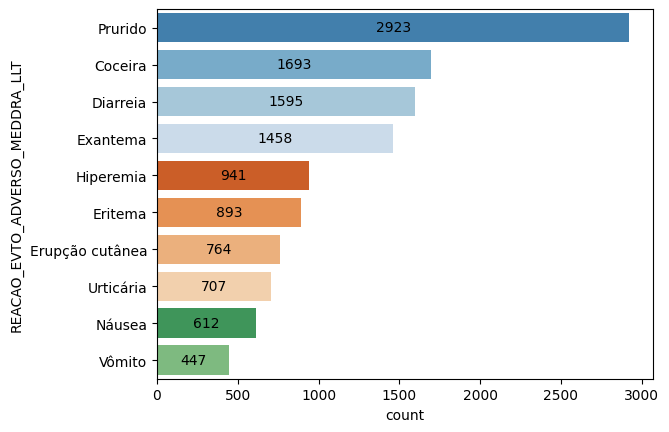

In [ ]:
# gráfico top10 reações pós filtros - antibióticos
ax = sns.barplot(data=top10_reacoes_ant.reset_index(), x="count", y="REACAO_EVTO_ADVERSO_MEDDRA_LLT", palette='tab20c')
# adicionando os labels de cada barra
for container in ax.containers:
    ax.bar_label(container, label_type='center')
plt.show()

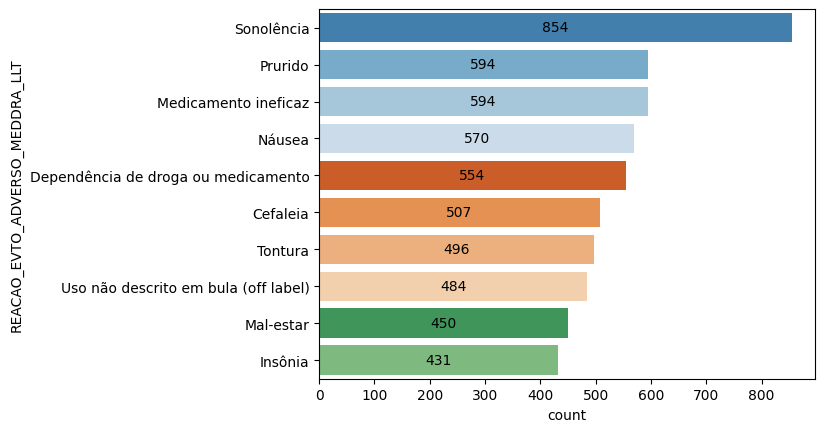

In [ ]:
# gráfico top10 reações pós filtros - psicotrópicos
ax = sns.barplot(data=top10_reacoes_psi.reset_index(), x="count", y="REACAO_EVTO_ADVERSO_MEDDRA_LLT", palette='tab20c')
# adicionando os labels de cada barra
for container in ax.containers:
    ax.bar_label(container, label_type='center')
plt.show()

In [ ]:
# concatenando as reações dos antibióticos e psicotrópicos
reacoes_pos_filtros = pd.concat([frequencia_reacoes_pos_filtros_ant, frequencia_reacoes_pos_filtros_psi], axis=1)
reacoes_pos_filtros.head()

,Frequeência de Reações - Antibióticos,Frequeência de Reações - Psicotrópicos
REACAO_EVTO_ADVERSO_MEDDRA_LLT,,
Prurido,458.0,311.0
Diarreia,221.0,201.0
Coceira,165.0,126.0
Exantema,153.0,110.0
Hiperemia,115.0,70.0


In [ ]:
# renomeando a coluna count
frequencia_reacoes_sem_filtro.rename(columns={'count':'Frequeência de Reações - Sem filtros'}, inplace=True)
frequencia_reacoes_sem_filtro.head()

,Frequeência de Reações - Sem filtros
REACAO_EVTO_ADVERSO_MEDDRA_LLT,
Cefaleia,13465
Prurido,12173
Febre,11722
Náusea,11497
Diarreia,8565


In [ ]:
# concatenando os dataframes de rações adversas doa antibióticos e psicotrópicos com o das reações sem filtro
frequencia_reacoes_total = pd.concat([reacoes_pos_filtros, frequencia_reacoes_sem_filtro], axis=1)
frequencia_reacoes_total.head()

,Frequeência de Reações - Antibióticos,Frequeência de Reações - Psicotrópicos,Frequeência de Reações - Sem filtros
REACAO_EVTO_ADVERSO_MEDDRA_LLT,,,
Prurido,458.0,311.0,12173
Diarreia,221.0,201.0,8565
Coceira,165.0,126.0,7747
Exantema,153.0,110.0,3634
Hiperemia,115.0,70.0,5001


In [ ]:
# transformando frequencia_reacoes_top10 em dataframe
top10_reacoes_geral = pd.DataFrame(frequencia_reacoes_top10)
top10_reacoes_geral.head()

,count
REACAO_EVTO_ADVERSO_MEDDRA_LLT,
Cefaleia,13465
Prurido,12173
Febre,11722
Náusea,11497
Diarreia,8565


In [ ]:
# juntando os dataframes de reacoes
# filtrando baseado nas top10 reaacoes geral
top10_reacoes = pd.merge(top10_reacoes_geral, frequencia_reacoes_pos_filtros_ant, on='REACAO_EVTO_ADVERSO_MEDDRA_LLT', how='left')
top10_reacoes = pd.merge(top10_reacoes, frequencia_reacoes_pos_filtros_psi, on='REACAO_EVTO_ADVERSO_MEDDRA_LLT', how='left')
top10_reacoes.head()

,count,Frequeência de Reações - Antibióticos,Frequeência de Reações - Psicotrópicos
REACAO_EVTO_ADVERSO_MEDDRA_LLT,,,
Cefaleia,13465,15,306
Prurido,12173,458,311
Febre,11722,30,117
Náusea,11497,73,329
Diarreia,8565,221,201


In [ ]:
top10_reacoes.shape

(10, 3)

In [ ]:
# renomeando coluna
top10_reacoes.rename(columns={'count':'Frequeência de Reações - Geral'}, inplace=True)
top10_reacoes.head()

,Frequeência de Reações - Sem filtros,Frequeência de Reações - Antibióticos,Frequeência de Reações - Psicotrópicos
REACAO_EVTO_ADVERSO_MEDDRA_LLT,,,
Cefaleia,13465,15,306
Prurido,12173,458,311
Febre,11722,30,117
Náusea,11497,73,329
Diarreia,8565,221,201


<ipython-input-84-4c0ede0cecc3>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  labels = [f'{(v / total_values_top10[i] * 100):.1f}%' if total_values_top10.iloc[i] > 0 else ''


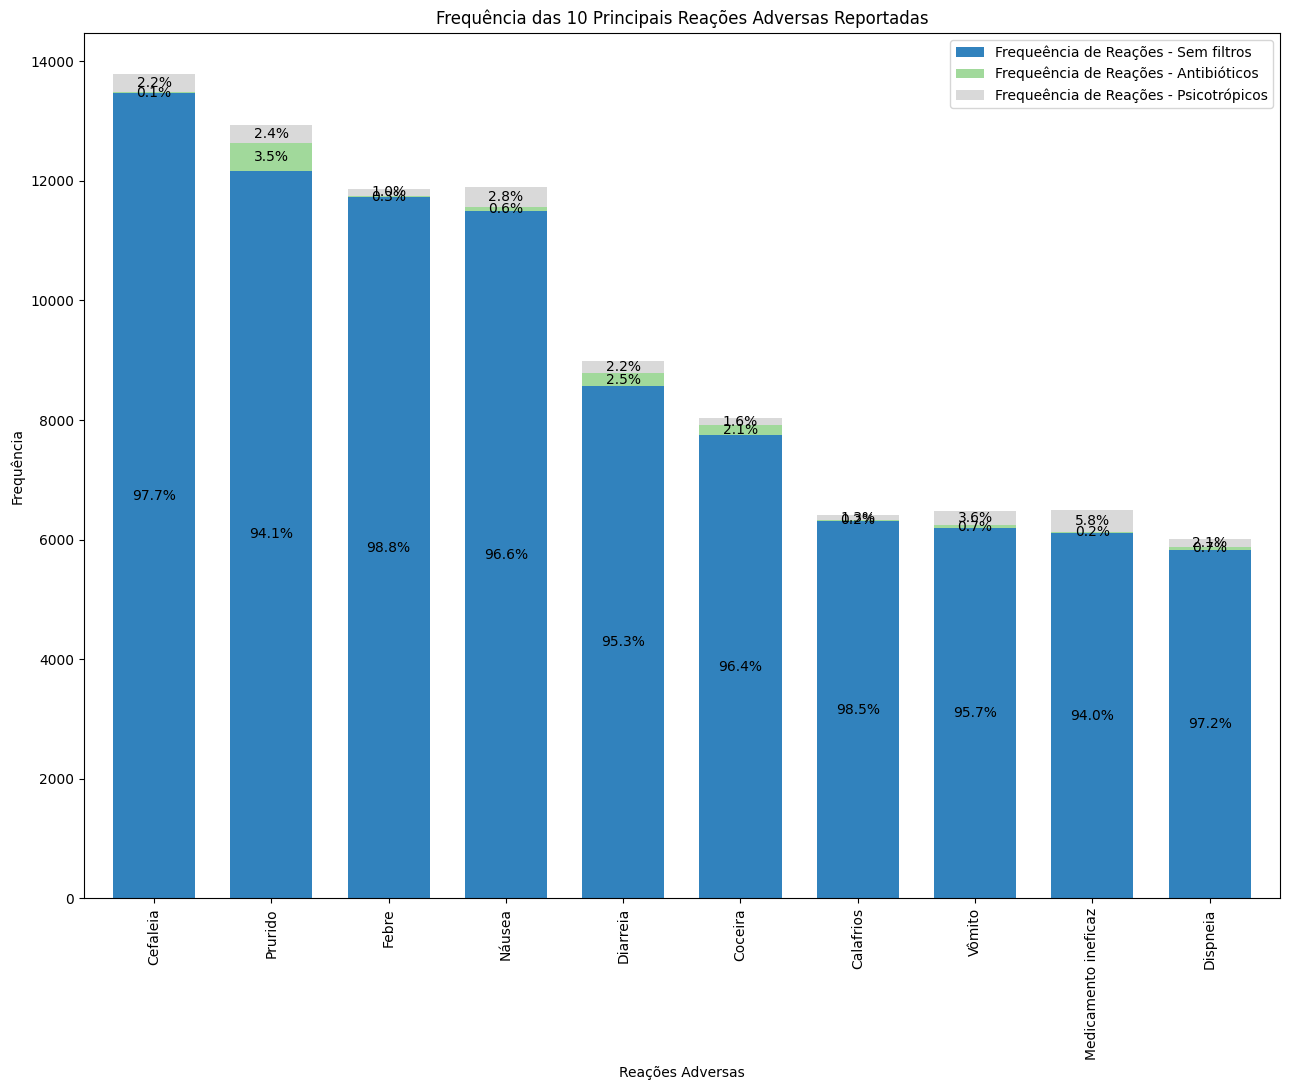

In [ ]:
# Gráfico de barras empilhadas com rótulos - top 10 reacoes adversas
total_values_top10 = top10_reacoes.sum(axis=1)
fig, ax = plt.subplots(figsize=(13, 11))

# Cria as barras empilhadas
top10_reacoes.plot(kind='bar', width=0.7, stacked=True, ax=ax, colormap='tab20c')

# Adiciona rótulos às barras
for container in ax.containers:
    labels = [f'{(v / total_values_top10[i] * 100):.1f}%' if total_values_top10.iloc[i] > 0 else ''
              for i, v in enumerate(container.datavalues)]
    ax.bar_label(container, labels=labels, label_type='center')

# Ajusta os rótulos e layout
plt.xlabel('Reações Adversas')
plt.ylabel('Frequência')
plt.title('Frequência das 10 Principais Reações Adversas Reportadas')
plt.xticks(rotation=90)
plt.tight_layout()

plt.show()

Avaliando IDs repetidos

In [ ]:
ids_repetidos_ant = pd.DataFrame(dados_ant['IDENTIFICACAO_NOTIFICACAO'].value_counts())

In [ ]:
ids_repetidos_psi = pd.DataFrame(dados_psi['IDENTIFICACAO_NOTIFICACAO'].value_counts())
ids_repetidos_psi.head()

,count
IDENTIFICACAO_NOTIFICACAO,
BR-ANVISA-300125972,536
BR-ANVISA-300134180,244
BR-ANVISA-300137444,216
BR-ANVISA-300148379,198
BR-ANVISA-300119125,180


In [ ]:
ids_repetidos_psi.rename(columns={'count':'Contagem IDs Psicotropicos'}, inplace=True)

In [ ]:
ids_repetidos_ant.rename(columns={'count':'Contagem IDs Antibióticos'}, inplace=True)

In [ ]:
ids_repetidos = pd.concat([ids_repetidos_psi, ids_repetidos_ant], axis=1)
ids_repetidos.head()

,Contagem IDs Psicotropicos,Contagem IDs Antibióticos
IDENTIFICACAO_NOTIFICACAO,,
BR-ANVISA-300125972,536.0,NaN
BR-ANVISA-300134180,244.0,NaN
BR-ANVISA-300137444,216.0,NaN
BR-ANVISA-300148379,198.0,NaN
BR-ANVISA-300119125,180.0,NaN


Convertendo dataframes para tabelas do excel


In [ ]:
dados_psi.to_excel('dados_psicotropicos.xlsx', index=False)

In [ ]:
dados_ant.to_excel('dados_antibioticos.xlsx', index=False)

In [ ]:
ids_repetidos.to_excel('IDs_repetidos.xlsx')

In [ ]:
frequencia_reacoes_sem_filtro.to_excel('frequencia_reacoes.xlsx')

In [ ]:
frequencia_reacoes_total.to_excel('frequencia_reacoes_total.xlsx')

In [ ]:
dados_totais.to_csv('dados_totais_vigimed.csv', index=False)

Bloco para salvar os gráficos em pdf

<ipython-input-85-7ad5b9a837a8>:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  labels = [f'{(v / total_values_noti[i] * 100):.1f}%' if total_values_noti.iloc[i] > 0 else ''


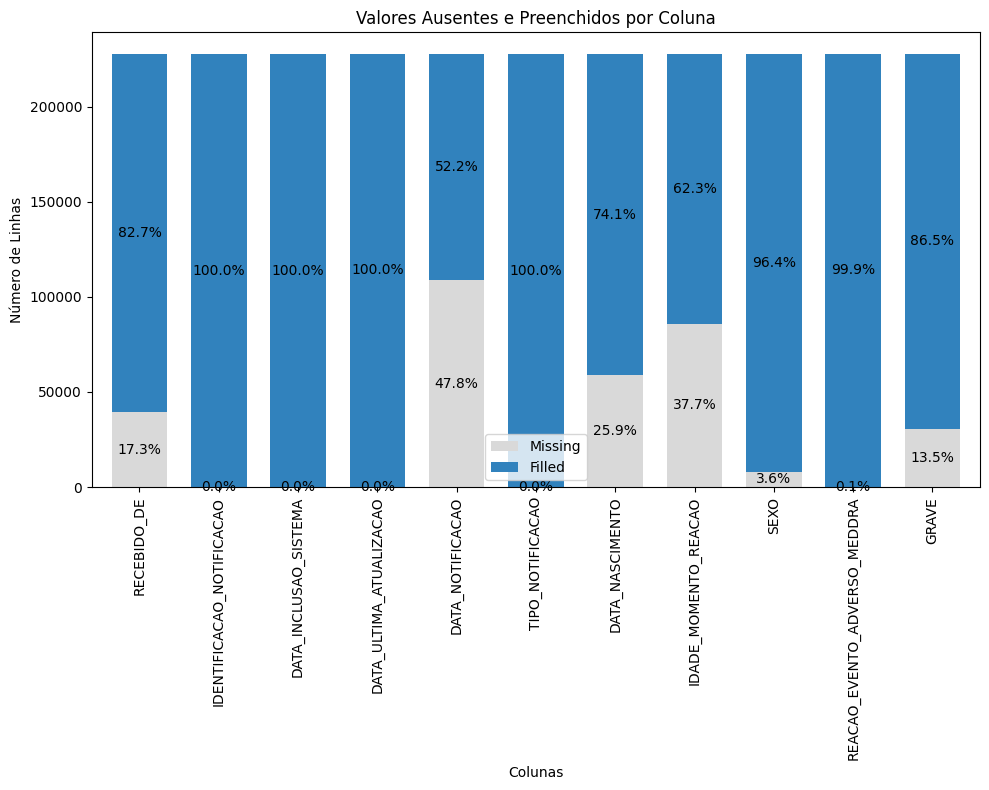

In [ ]:
# Gráfico de barras empilhadas com rótulos - Dataframe Notificações
with PdfPages('preenchimento_notificacoes.pdf') as pp:
  total_values_noti = noti_missing_filled.sum(axis=1)
  fig, ax = plt.subplots(figsize=(10, 8))
  noti_missing_filled.plot(kind='bar', width=0.7, stacked=True, ax=ax, colormap='tab20c_r')
  for container in ax.containers:
    labels = [f'{(v / total_values_noti[i] * 100):.1f}%' if total_values_noti.iloc[i] > 0 else ''
              for i, v in enumerate(container.datavalues)]
    ax.bar_label(container, labels=labels, label_type='center')
  plt.xlabel('Colunas')
  plt.ylabel('Número de Linhas')
  plt.title('Valores Ausentes e Preenchidos por Coluna')
  plt.xticks(rotation=90)
  plt.tight_layout()
  pp.savefig()

<ipython-input-86-687dbc5f7e16>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  labels = [f'{(v / total_values_reac[i] * 100):.1f}%' if total_values_reac.iloc[i] > 0 else ''


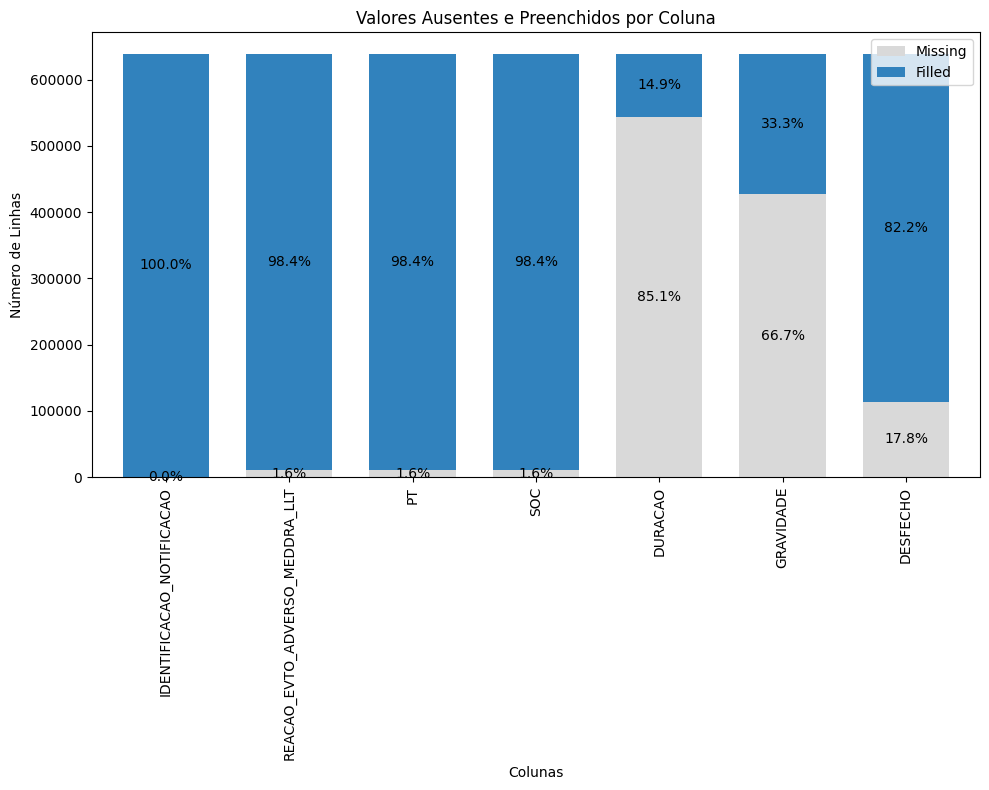

In [ ]:
with PdfPages('preenchimento_reacoes.pdf') as pp:
  total_values_reac = reac_missing_filled.sum(axis=1)
  fig, ax = plt.subplots(figsize=(10, 8))
  reac_missing_filled.plot(kind='bar', width=0.7, stacked=True, ax=ax, colormap='tab20c_r')
  for container in ax.containers:
    labels = [f'{(v / total_values_reac[i] * 100):.1f}%' if total_values_reac.iloc[i] > 0 else ''
              for i, v in enumerate(container.datavalues)]
    ax.bar_label(container, labels=labels, label_type='center')
  plt.xlabel('Colunas')
  plt.ylabel('Número de Linhas')
  plt.title('Valores Ausentes e Preenchidos por Coluna')
  plt.xticks(rotation=90)
  plt.tight_layout()
  pp.savefig()

<ipython-input-87-34bb34a304ec>:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  labels = [f'{(v / total_values_med[i] * 100):.1f}%' if total_values_med.iloc[i] > 0 else ''


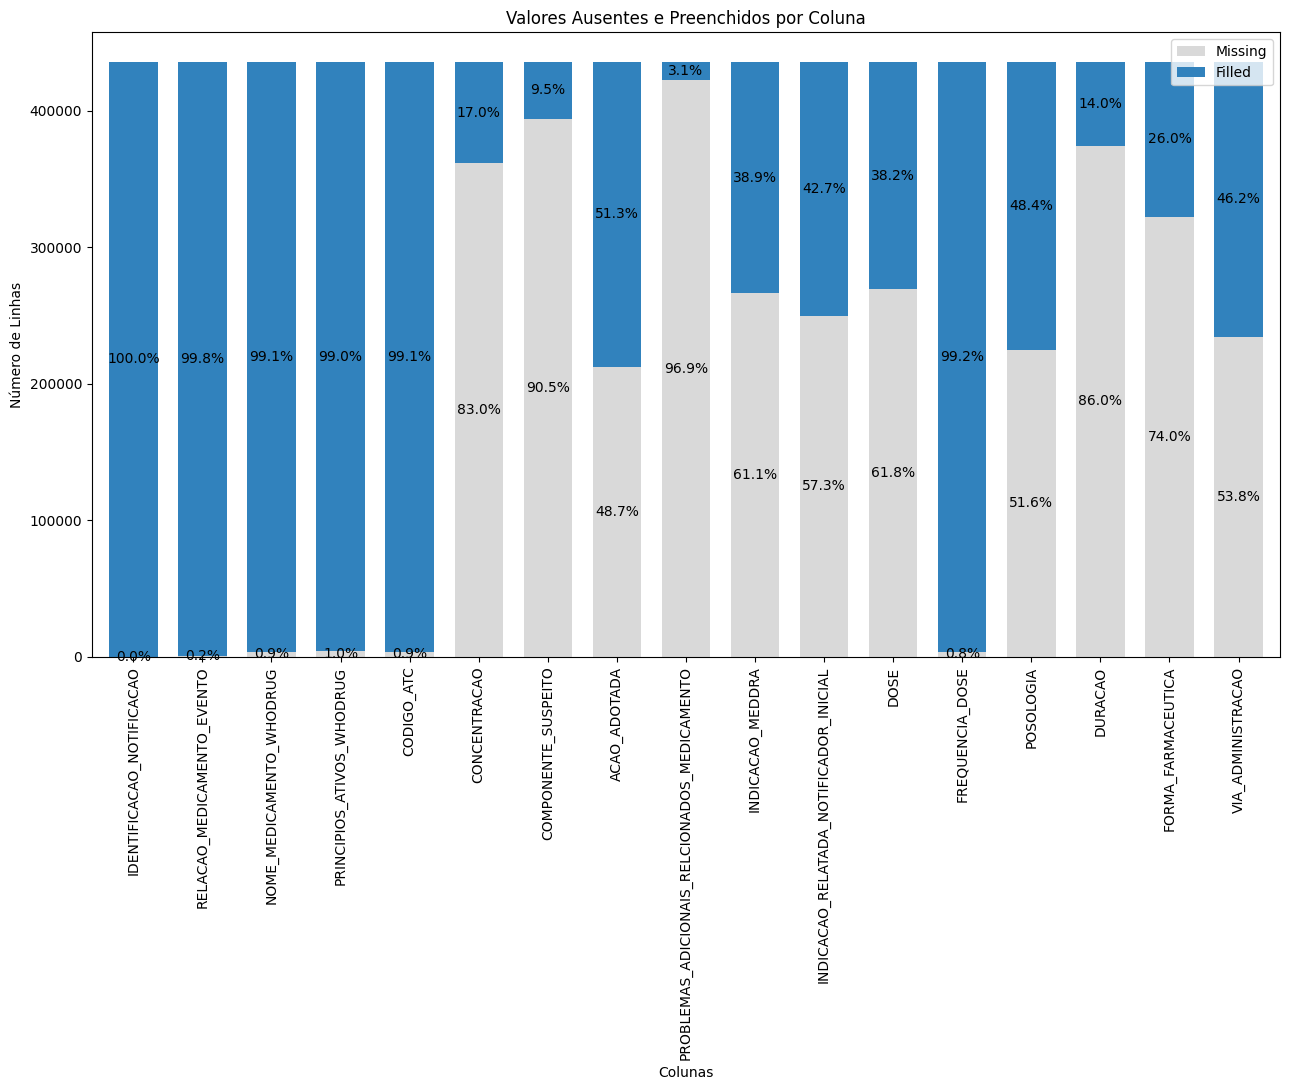

In [ ]:
# Gráfico de barras empilhadas com rótulos - Dataframe Medicamentos
with PdfPages('preenchimento_medicamentos.pdf') as pp:
  total_values_med = med_missing_filled.sum(axis=1)
  fig, ax = plt.subplots(figsize=(13, 11))
  med_missing_filled.plot(kind='bar', width=0.7, stacked=True, ax=ax, colormap='tab20c_r')
  for container in ax.containers:
    labels = [f'{(v / total_values_med[i] * 100):.1f}%' if total_values_med.iloc[i] > 0 else ''
              for i, v in enumerate(container.datavalues)]
    ax.bar_label(container, labels=labels, label_type='center')
  plt.xlabel('Colunas')
  plt.ylabel('Número de Linhas')
  plt.title('Valores Ausentes e Preenchidos por Coluna')
  plt.xticks(rotation=90)
  plt.tight_layout()
  pp.savefig()

<ipython-input-88-403481856be2>:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  labels = [f'{(v / total_values_top10[i] * 100):.1f}%' if total_values_top10.iloc[i] > 0 else ''


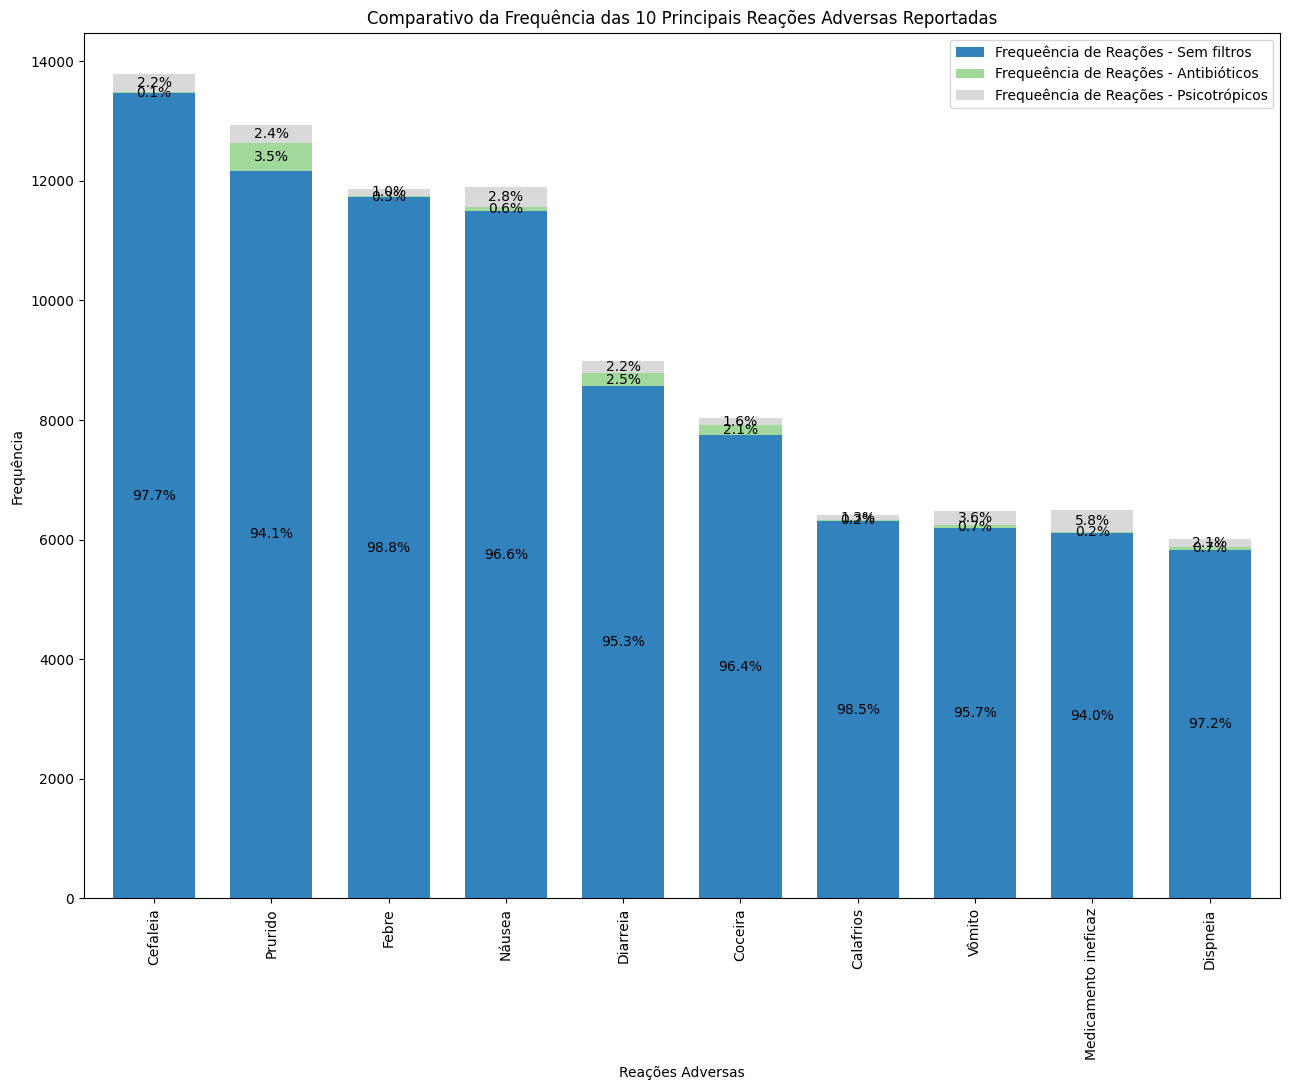

In [ ]:
# Gráfico de barras empilhadas com rótulos - top 10 reacoes adversas
with PdfPages('top10_reacoes_comparativo.pdf') as pp:
  total_values_top10 = top10_reacoes.sum(axis=1)
  fig, ax = plt.subplots(figsize=(13, 11))
  top10_reacoes.plot(kind='bar', width=0.7, stacked=True, ax=ax, colormap='tab20c')
  for container in ax.containers:
    labels = [f'{(v / total_values_top10[i] * 100):.1f}%' if total_values_top10.iloc[i] > 0 else ''
              for i, v in enumerate(container.datavalues)]
    ax.bar_label(container, labels=labels, label_type='center')
  plt.xlabel('Reações Adversas')
  plt.ylabel('Frequência')
  plt.title('Comparativo da Frequência das 10 Principais Reações Adversas Reportadas')
  plt.xticks(rotation=90)
  plt.tight_layout()
  pp.savefig()

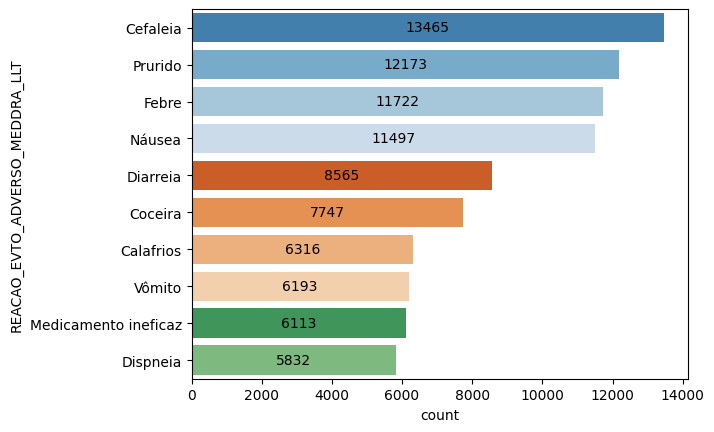

In [ ]:
# criando um gráfico de barras, utilizando a biblioteca seaborn, para visualizar as 10 reações mais frequentes - geral
with PdfPages('top10_reacoes_geral.pdf') as pp:
  ax = sns.barplot(data=frequencia_reacoes_top10.reset_index(), x="count", y="REACAO_EVTO_ADVERSO_MEDDRA_LLT", palette="tab20c")
  for container in ax.containers:
    ax.bar_label(container, label_type='center')
  pp.savefig()

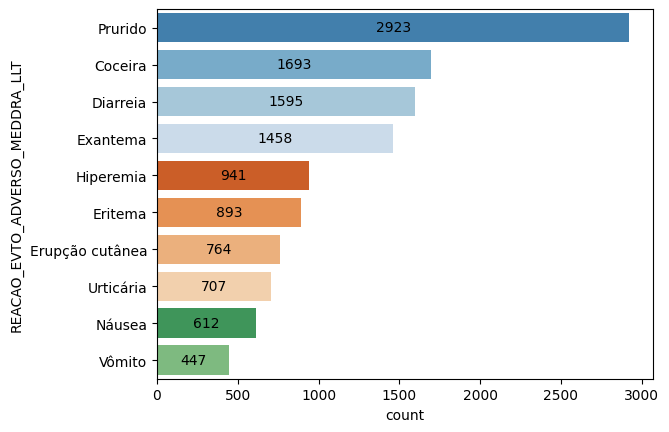

In [ ]:
# criando um gráfico de barras, utilizando a biblioteca seaborn, para visualizar as 10 reações mais frequentes - antibióticos
with PdfPages('top10_reacoes_antibioticos.pdf') as pp:
  ax = sns.barplot(data=top10_reacoes_ant.reset_index(), x="count", y="REACAO_EVTO_ADVERSO_MEDDRA_LLT", palette="tab20c")
  for container in ax.containers:
    ax.bar_label(container, label_type='center')
  pp.savefig()

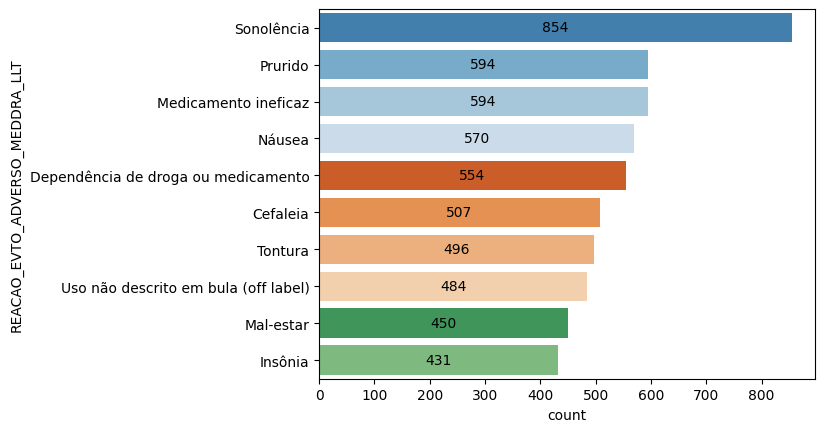

In [ ]:
# criando um gráfico de barras, utilizando a biblioteca seaborn, para visualizar as 10 reações mais frequentes - psicotrópicos
with PdfPages('top10_reacoes_psicotropicos.pdf') as pp:
  ax = sns.barplot(data=top10_reacoes_psi.reset_index(), x="count", y="REACAO_EVTO_ADVERSO_MEDDRA_LLT", palette="tab20c")
  for container in ax.containers:
    ax.bar_label(container, label_type='center')
  pp.savefig()